In [1]:
%load_ext autoreload
%autoreload 2

import cvxpy as cp

import numpy as np
from scipy.optimize import minimize
import ipi_project as ipi
import phantoms
from skimage.filters import gaussian

import scipy.optimize

import matplotlib.pyplot as plt

import astra

from topolar import topolar

import scipy.sparse
from matrixT import create_T
from matrixT import create_Dx
from matrixT import create_Blur
from matrixT import create_Mask

18.10193359837562


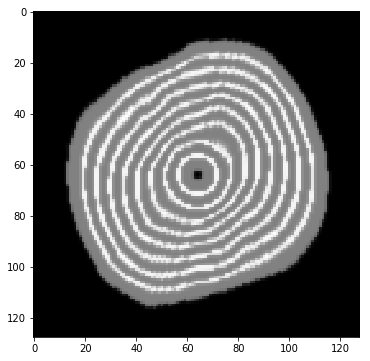

18.10193359837562


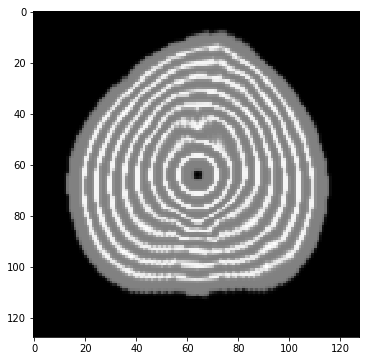

18.10193359837562


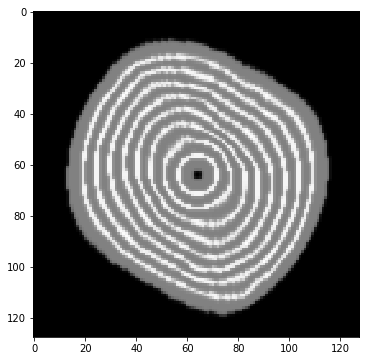

18.10193359837562


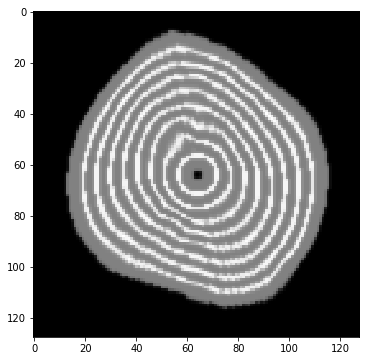

18.10193359837562


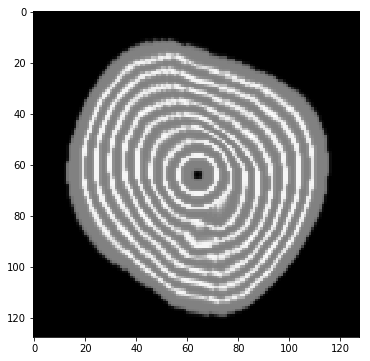

In [2]:
circle = phantoms.circle(128,12, wall_thickness=7)
#circle = np.pad(circle, pad_width=10, mode='constant', constant_values=0)
circle = gaussian(circle, sigma=0.5, preserve_range=True)
for _ in range(5):
    wobbly, src, inv_src = phantoms.wobbly_transform(circle, amplitude=5)
    #wobbly = gaussian(wobbly, sigma=1.0, preserve_range=True)


    plt.figure(figsize=(6,6))
    plt.imshow(wobbly, cmap='gray')
    plt.show()

In [3]:
circle_offcenter = np.zeros_like(circle)
pixel_shift = 5
x,y = circle.shape
circle_offcenter[0:(x - 2*pixel_shift),0:(y - 2*pixel_shift)] = (
    circle[pixel_shift:(x-pixel_shift), pixel_shift:(y-pixel_shift)])

In [4]:
proj_angles = np.linspace(0, 2.0*np.pi, 180)
W, proj_id = ipi.create_OpTomo(circle.shape[0], proj_size=150, proj_angles=proj_angles)

matrix_id = astra.projector.matrix(proj_id)

A = astra.matrix.get(matrix_id)

def polar_and_sinogram(phantom, proj_id, plot=False):

    sino = astra.creators.create_sino(phantom, proj_id)[1]

    polar = topolar(phantom)[0]

    if plot:
        plt.figure(figsize=(8,8))
        plt.imshow(phantom, cmap='gray')
        plt.show()
        
        plt.figure(figsize=(8,8))
        plt.imshow(polar, cmap='gray')
        plt.show()
        #plt.imshow(sino, cmap='gray')
        #plt.show()
        
    return polar, sino
    

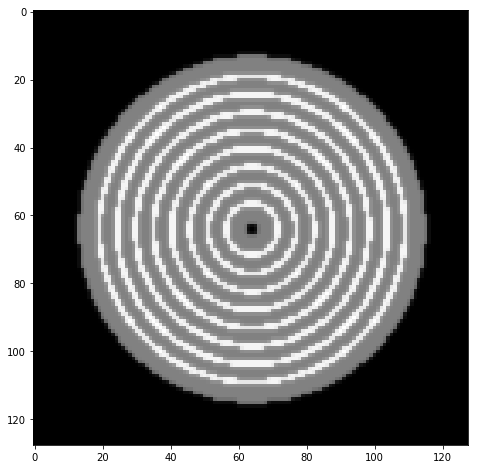

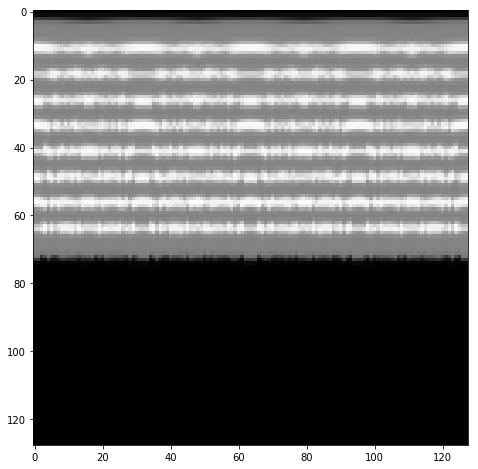

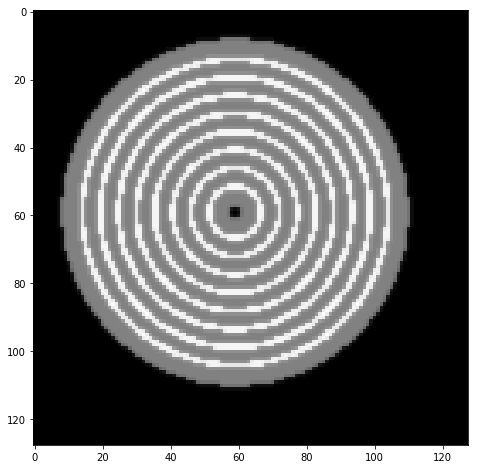

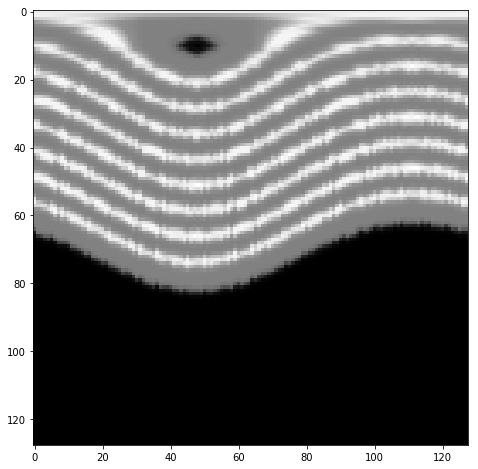

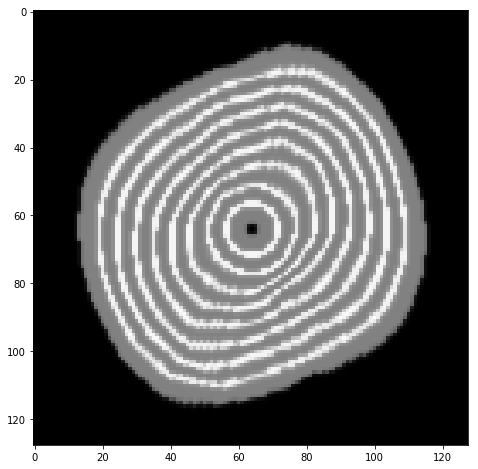

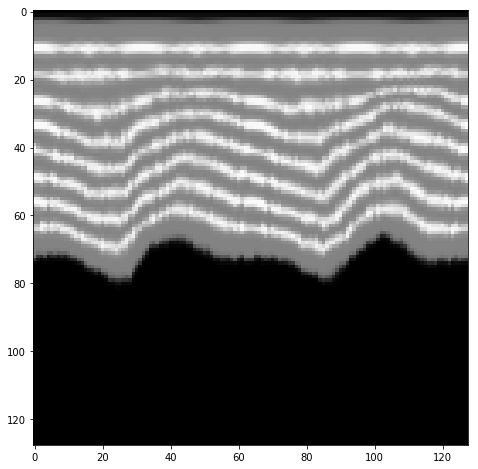

In [8]:
    
polar_circle, sino_circle = polar_and_sinogram(circle, proj_id, plot=True)
polar_circle_offcenter, sino_circle_offcenter = polar_and_sinogram(circle_offcenter, proj_id, plot=True)
polar_wobbly, sino_wobbly = polar_and_sinogram(wobbly, proj_id, plot=True)

In [ ]:
Tmat = create_T(128)
Tmat_sparse = scipy.sparse.csr_matrix(Tmat)
Dx_sparse = create_Dx(128)
Mask = create_Mask(128, 64)

In [ ]:
sinograms = [(sino_circle, 'circle'), 
             (sino_circle_offcenter, 'circle_offcenter'),
            (sino_wobbly, 'wobbly')]

reg_lambdas = np.linspace(0.0, 3, 4)
pnorms = [2]

In [34]:
def reconstruct_with_constraints(A, y_sino, Mask, Tmat, Dx, reg_lambda, regnorm):
    print(A.shape)
      
    
    def loss_fn(A, x, y_sino):
        Tmat_x = cp.matmul(Tmat, x)
        Mask_tmat = cp.matmul(Mask, Tmat_x)
        Dx_mask = cp.matmul(Dx, Mask_tmat)
        if regnorm == 1:
            return cp.pnorm(cp.matmul(A, x) - y_sino, p=2)**2 + reg_lambda*cp.norm(Dx_mask, p=1)
        elif regnorm == 2:
            return cp.pnorm(cp.matmul(A, x) - y_sino, p=2)**2 + reg_lambda*cp.norm(Dx_mask, p=2)**2
    
    x = cp.Variable(128*128)
    constraints = [0 <= x]
    problem = cp.Problem(cp.Minimize(loss_fn(A, x, y_sino)), constraints)
    problem.solve(verbose=True, solver=cp.OSQP)
    return x

In [13]:
plt.imsave('circle.png', circle, cmap='gray')

In [ ]:
noise = np.random.randn(*sino_circle.shape)

for l in reg_lambdas:
    for pnorm in pnorms:
        for sinogram in sinograms:
            y_delta = sinogram[0] + noise
        
            solution = reconstruct_with_constraints(A, y_delta.ravel(), Mask, Tmat, Dx_sparse, l, pnorm)
            image = solution.value.reshape(128,128)
            img_name = "{}_l_{}_p_{}_mk2.png".format(sinogram[1],l, pnorm)
            numpy_name = "{}_l_{}_p_{}_mk2.npy".format(sinogram[1],l, pnorm)
            np.save(numpy_name, image)
            plt.imsave(img_name, image, cmap='gray')

(27000, 16384)


In [21]:
image.shape

(128, 128)

In [22]:
plt.imsave("test.png", image)

In [28]:
np.save("cirle_phantom", circle)
np.save("wobbly_phantom", wobbly)
np.save("circle_offcenter", circle_offcenter)

plt.imsave("circle_off_center_phantom.png", circle_offcenter, cmap='gray')
plt.imsave("circle_phantom.png", circle, cmap='gray')
plt.imsave("wobbly_phantom.png", wobbly, cmap='gray')


plt.imsave("circle_off_center_polar.png", polar_circle_offcenter, cmap='gray')
plt.imsave("circle_polar.png", polar_circle, cmap='gray')
plt.imsave("wobbly_polar.png", polar_wobbly, cmap='gray')

In [30]:
print(cp.installed_solvers())

['SCS', 'ECOS_BB', 'ECOS', 'OSQP']
